# Solutions: analyse a pulse using `pandas` and `numpy`

This notebook contains a short exercise to quickly practice the concepts introduced in the section 1, namely `numpy` computation, importations/manipulation with `pandas` and plotting with `matplotlib`. The play ground is an electric signal delivered by a calorimeter readout electronics, measured with a scope and saved as `csv` file, loaded just below. The first column is the time (in second) and the second is the voltage (in volt).

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# skip the first 15 lines, rename the column and specify the type (float)
pulse_df = pd.read_csv('pulse.csv', skiprows=15, names=['T', 'V'], dtype=np.float64)
pulse_df.head(10)

,T,V
0,-4.000000e-08,-0.437750
1,-3.960000e-08,-0.437547
2,-3.920000e-08,-0.437109
3,-3.880000e-08,-0.437016
4,-3.840000e-08,-0.436938
5,-3.800000e-08,-0.436781
6,-3.760000e-08,-0.436422
7,-3.720000e-08,-0.437000
8,-3.680000e-08,-0.437750
9,-3.640000e-08,-0.439312


## Plot the pulse before transformation

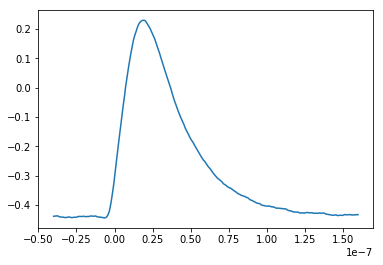

In [2]:
plt.plot(pulse_df['T'], pulse_df['V']);

## Transforming the pulse

### Add a column with the time in ns `Tns` -- and plot the result

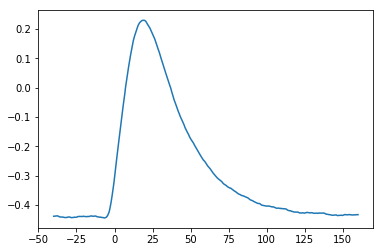

In [3]:
pulse_df['Tns'] = pulse_df['T'] * 1e9
plt.plot(pulse_df['Tns'], pulse_df['V']);

### Compute the pedestal (base-line of the pulse)

In [4]:
V = pulse_df['V'].values
Vnorm = V - np.mean(V[:50])

### Add a column with pedestal-substracted voltage `Vnorm` -- and plot the result

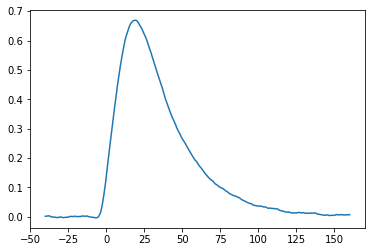

In [5]:
pulse_df['Vnorm'] = Vnorm
plt.plot(pulse_df['Tns'], pulse_df['Vnorm']);

### Normalize `Vnorm` to have a minumu of 0.0 and a maximum amplitude of 1.0 -- and plot the result

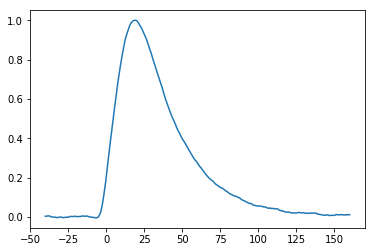

In [6]:
pulse_df['Vnorm'] = Vnorm/np.max(Vnorm)
plt.plot(pulse_df['Tns'], pulse_df['Vnorm']);

### Find `Tmax` which has the max amplitude (HINT: checkout `np.argmax()` function)

In [7]:
Tns = pulse_df['Tns'].values
Tmax = Tns[np.argmax(Vnorm)]
print('Tmax = {:.1f} ns'.format(Tmax))

Tmax = 18.8 ns


### Plot the pulse with `Tmax=0`, `Vmin=0`, `Vmax=1`

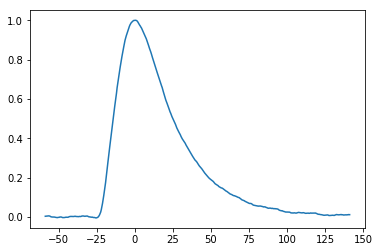

In [8]:
pulse_df['Tnorm'] = Tns-Tmax
plt.plot(pulse_df['Tnorm'], pulse_df['Vnorm']);

## Pulse caracterization

### Compute the full width at half maximum (FWHM)

In [9]:
# Get numpy arrays and index of max
Vnorm = pulse_df['Vnorm'].values
Tnorm = pulse_df['Tnorm'].values
imax = np.argmax(Vnorm)

# 1. Compte the first time with V=0.5 (ramp-up)
Vup, Tup = Vnorm[:imax], Tnorm[:imax]
T1 = Tup[np.argmin(np.abs(Vup-0.5))]

# 2. Compute the second time with V=0.5 (ramp-down)
Vdo, Tdo = Vnorm[imax:], Tnorm[imax:] 
T2 = Tdo[np.argmin(np.abs(Vdo-0.5))]

# 3. Print the result
print('FWHM = {:.1f} ns'.format(T2-T1))

FWHM = 39.6 ns


### Compute and plt the cumulative sum of the pulse using the proper `ufunc`

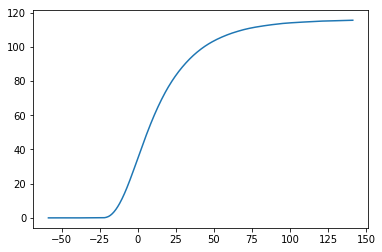

In [10]:
Vcumul = np.cumsum(Vnorm)
plt.plot(Tnorm, Vcumul);

### Perform a fit of the peak by a gaussian on the time window $[-10, 10]$ ns

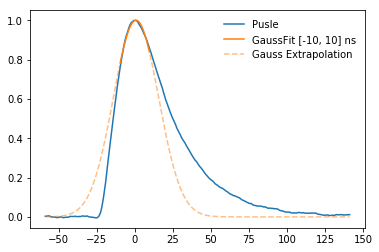

In [22]:
from scipy import optimize

# Fitting function
def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Defining the range
points_fit = (Tnorm<10) & (Tnorm>-10)

# Doing the fit on the specifed range
par, cov = optimize.curve_fit(Gauss, Tnorm[points_fit], Vnorm[points_fit])

# Plotting the data over the full range
plt.plot(Tnorm, Vnorm, label='Pusle')

# Plotting the fit in the time window
plt.plot(Tnorm[points_fit], Gauss(Tnorm[points_fit], *par), label='GaussFit [-10, 10] ns')

# Plotting the fit extrapolation outside
plt.plot(Tnorm[Tnorm<=-10], Gauss(Tnorm[Tnorm<=-10], *par), linestyle='--', color='tab:orange', alpha=0.5)
plt.plot(Tnorm[Tnorm>=10], Gauss(Tnorm[Tnorm>=10], *par), alpha=0.5,
         label='Gauss Extrapolation', linestyle='--', color='tab:orange')

# Plotting the legend
plt.legend(frameon=False);